# **Add parent directory to python path**

In [1]:
import os
import sys

parent_dir = os.path.join(os.getcwd(), '..')
sys.path.append(parent_dir)

Colab

In [ ]:
# !git clone https://github.com/ycc789741ycc/anime-recommender-system.git
# %cd /content/anime-recommender-system/

# INPUT_DIR = '/content/drive/MyDrive/Colab\ Notebooks/Anime_Recommender_system/data'
# !ls {INPUT_DIR}
# !unzip /content/drive/MyDrive/Colab\ Notebooks/Anime_Recommender_system/data/animelist.csv.zip

# **Logger setting**

In [2]:
import logging

logger = logging.getLogger()

chandler = logging.StreamHandler()
chandler.setLevel(logging.DEBUG)

logger.addHandler(chandler)
logger.setLevel(logging.INFO)


# **Load Data**

In [3]:
INPUT_DIR = '../data'
!ls {INPUT_DIR}

animelist_min.csv


In [34]:
import numpy as np
import pandas as pd

rating_df_iter = pd.read_csv(INPUT_DIR + '/animelist_min.csv', 
                        low_memory=False, 
                        usecols=["user_id", "anime_id", "rating"],
                        chunksize=128
                        )

rating_df = pd.concat(rating_df_iter)
rating_df.head(4)

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0


In [35]:
# User should rate atleast 400 animies
n_ratings = rating_df['user_id'].value_counts()
rating_df = rating_df[rating_df['user_id'].isin(n_ratings[n_ratings >= 400].index)].copy()
len(rating_df)

10801

In [36]:
# Scaling BTW (0 , 1.0)
min_rating = min(rating_df['rating'])
max_rating = max(rating_df['rating'])
rating_df['rating'] = rating_df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values.astype(np.float64)

AvgRating = np.mean(rating_df['rating'])
print('Avg', AvgRating)

Avg 0.33328395518933435


In [37]:
# Removing Duplicated Rows
duplicates = rating_df.duplicated()

if duplicates.sum() > 0:
    print('> {} duplicates'.format(duplicates.sum()))
    rating_df = rating_df[~duplicates]

print('> {} duplicates'.format(rating_df.duplicated().sum()))

> 0 duplicates


## **Data Preprocessing**

In [38]:
# Encoding categorical data
user_ids = rating_df["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded2user = {i: x for i, x in enumerate(user_ids)}
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)
n_users = len(user2user_encoded)

anime_ids = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x: i for i, x in enumerate(anime_ids)}
anime_encoded2anime = {i: x for i, x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)
n_animes = len(anime2anime_encoded)

field_dims = [n_users, n_animes]

print("Num of users: {}, Num of animes: {}".format(n_users, n_animes))
print("Min rating: {}, Max rating: {}".format(min(rating_df['rating']), max(rating_df['rating'])))

Num of users: 14, Num of animes: 4221
Min rating: 0.0, Max rating: 1.0


In [39]:
# Shuffle
rating_df = rating_df.sample(frac=1, random_state=73)

df_x = rating_df[['user', 'anime']]
df_y = rating_df[["rating"]]

# **Training config**

In [40]:
from schema.training import TrainingConfig

training_config = TrainingConfig(
    batch_size=32,
    epochs=10,
    n_workers=4,
    model_size=1000,
    lr_factor=2.,
    lr_warm_up=2000
)

# **Load data into tensor**

In [41]:
import torch

from training.functools import get_dataloader
from training.dataset import MyDataSet


dataset = MyDataSet(df_x=df_x, df_y=df_y)
train_loader, valid_loader, test_loader = get_dataloader(
    dataset=dataset,
    batch_size=training_config.batch_size,
    n_workers=training_config.n_workers,
    valid_ratio=0.1,
    test_ratio=0.1
)

# **Import the model**

In [42]:
from recommender.ranking_base_filter.model import FactorizationMachineModel

model = FactorizationMachineModel(
    field_dims=field_dims,
    embed_dim=16
)

# **Train the model** 

optimizer

In [43]:
from training.trainer import NoamOpt

optimizer = NoamOpt(
    **training_config.get_optimizer_config(),
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001)
)

loss criterion

In [44]:
import torch.nn as nn

loss_criterion = nn.MSELoss()

In [45]:
from training.trainer import ModelTrainer


cuda = torch.cuda.is_available()  
device = torch.device('cuda' if cuda else 'cpu')

model_trainer = ModelTrainer(
    train_loader=train_loader,
    valid_loader=valid_loader,
    model=model,
    loss_criterion=loss_criterion,
    optimizer=optimizer,
    device=device
)

Start to train

In [46]:
training_loss_history = np.array([])
valid_loss_history = np.array([])

for epoch in range(training_config.epochs):
    training_status = model_trainer.training_one_epoch()
    # training_loss_history = np.append(training_loss_history, np.array(training_status['loss_mean']))
    # valid_loss_history = np.append(valid_loss_history, valid_loss)

train epoch 1:   0%|          | 0/270 [00:00<?, ?it/s]/home/yoshi/miniconda3/envs/ml/lib/python3.8/site-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
/home/yoshi/miniconda3/envs/ml/lib/python3.8/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/home/yoshi/miniconda3/envs/ml/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
train epoch 1:  67%|██████▋   | 1

plot the training history

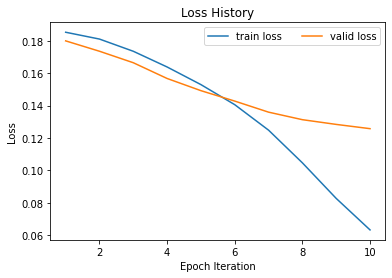

In [19]:
from training.functools import training_loss_epoch_mean_visualization


training_status = model_trainer.export_training_status()
train_epoch_x = list(training_status.train_loss_epoch_mean.keys())
train_loss_y = list(training_status.train_loss_epoch_mean.values())
valid_epoch_x = list(training_status.valid_loss_epoch_mean.keys())
valid_loss_y = list(training_status.valid_loss_epoch_mean.values())

training_loss_epoch_mean_visualization(
    epoch_x=train_epoch_x,
    train_loss_y=train_loss_y,
    valid_loss_y=valid_loss_y
)